In [1]:
from google.colab import drive
drive.mount('/drive')
PATH = '/drive/My Drive/news/'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


dataset = pd.read_csv(PATH+'news.csv', index_col=0)
dataset.head()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,news,source
0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,Практически во всех странах мира введены огра...,0.0
3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,Совет директоров «Почты России» проголосовал ...,2.0


In [2]:
dataset.source.value_counts()

1.0    11698
0.0     3455
2.0     3207
Name: source, dtype: int64

In [3]:
dataset[dataset.source.isna()]

,news,source
18360,Глава форума Reddit Стив Хаффман раскритикова...,NaN
18361,Французское архитектурное бюро Vincent Calleb...,NaN
18362,"Samsung провела мероприятие Galaxy Unpacked, ...",NaN
18363,В бета-версии клиента Telegram для Android с ...,NaN
18364,Журналистам из XDA удалось раздобыть минималь...,NaN
...,...,...
19457,С 17 декабря в России блокируется один из кру...,NaN
19458,Первые упоминания разработки тёмной темы в Go...,NaN
19459,Компания Oppo презентовала два новых продукта...,NaN
19460,"Основой презентации стала Windows 10, которая...",NaN


In [4]:
maxWordsCount = 20000

# токенизируем на уровне символов
tokenizer = Tokenizer(num_words=maxWordsCount)
# формируем токены на основе частотности в нашем тексте
tokenizer.fit_on_texts(dataset.news)

num_characters = len(tokenizer.word_index)+1
num_characters

207042

In [5]:
# Обучающие тесты в индексы
trainWordIndexes = tokenizer.texts_to_sequences(dataset[dataset.source.notna()].news)

# Проверочные тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(dataset[dataset.source.isna()].news)

In [6]:
print(len(trainWordIndexes))
print(len(trainWordIndexes[0]))

18360
65


In [7]:
x_train = tokenizer.sequences_to_matrix(trainWordIndexes)
x_train.shape

(18360, 20000)

In [8]:
x_test = tokenizer.sequences_to_matrix(testWordIndexes)
x_test.shape

(1102, 20000)

In [9]:
y_train = dataset[dataset.source.notna()].source
y_train.shape

(18360,)

Epoch 1/10
137/137 [==============================] - 9s 63ms/step - loss: 0.1055 - accuracy: 0.9644 - val_loss: 0.0775 - val_accuracy: 0.9771
Epoch 2/10
137/137 [==============================] - 8s 61ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.0498 - val_accuracy: 0.9847
Epoch 3/10
137/137 [==============================] - 8s 61ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.0406 - val_accuracy: 0.9891
Epoch 4/10
137/137 [==============================] - 8s 61ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.0391 - val_accuracy: 0.9891
Epoch 5/10
137/137 [==============================] - 8s 61ms/step - loss: 5.8634e-04 - accuracy: 0.9999 - val_loss: 0.0425 - val_accuracy: 0.9880
Epoch 6/10
137/137 [==============================] - 8s 61ms/step - loss: 6.0993e-04 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9902
Epoch 7/10
137/137 [==============================] - 8s 61ms/step - loss: 3.0182e-04 - accuracy: 1.0000 - val_loss: 0.0405 - val_accu

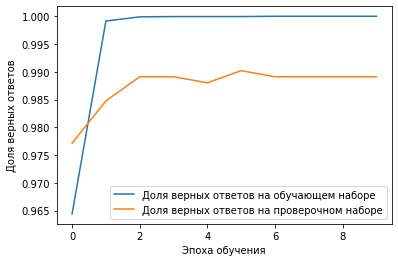

In [10]:
#Создаём полносвязную сеть
model = Sequential()
model.add(Dense(200, input_dim=x_test.shape[1], activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.05)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [11]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
pred

array([0, 1, 1, ..., 1, 0, 1])

In [12]:
result = dataset[dataset.source.isna()].drop(columns=['news'])
result.source = pred
result

,source
18360,0
18361,1
18362,1
18363,1
18364,1
...,...
19457,1
19458,1
19459,1
19460,0


In [13]:
result.source.value_counts()

1    706
0    218
2    178
Name: source, dtype: int64

In [14]:
result.to_csv(PATH+'submission.csv', header=False, index=False)